# Decision Tree

Initially, we try to use decision tree to evaluate the feasibility of random forest.
And get appropriate parameters(maxDepth, minLeaf). 

In [67]:
import numpy as np;
import matplotlib.pyplot as plt;
import mltools as ml;

X_test_src = np.genfromtxt("data/X_test.txt",delimiter=','); 
X_train_src = np.genfromtxt("data/X_train.txt",delimiter=','); # shape = (20k, 13)
Y_train_src = np.genfromtxt("data/Y_train.txt",delimiter=','); # Y = [0, 1]

X_test_src = X_test_src[1:,:];
X_train_src = X_train_src[1:,:];
Y_train_src = Y_train_src[1:];

Xtr,Ytr = X_train_src[0:18000,:], Y_train_src[0:18000];
Xv,Yv = X_train_src[18000:-1,:], Y_train_src[18000:-1] ;

In [68]:
print('X_test.shape =', X_test_src.shape);
print('X_train.shape =', X_train_src.shape);
print('Y_train.shape =', Y_train_src.shape);

X_test.shape = (10000, 13)
X_train.shape = (20000, 13)
Y_train.shape = (20000,)


maxDepth

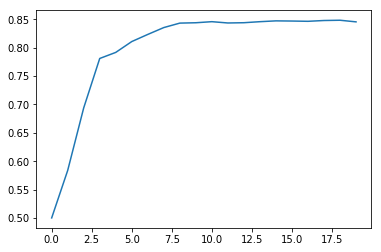

In [9]:
aucs = [];

for i in range(20):
    learner = ml.dtree.treeClassify(Xt, Yt, maxDepth = i);
    aucs.append(learner.auc(Xv, Yv));
    
plt.plot(aucs);
plt.show();

maxDepth = 8;

minLeaf

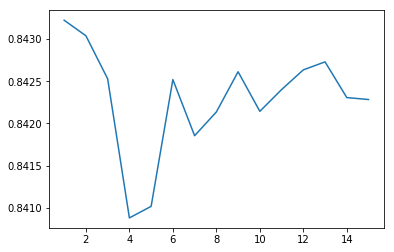

In [12]:
aucs = [];
leafs = [x*1 for x in range(1,16)]

for i in leafs:
    learner = ml.dtree.treeClassify(Xt, Yt, maxDepth=8, minLeaf=i);
    aucs.append(learner.auc(Xv, Yv));
    
plt.plot(leafs, aucs);
plt.show();

minLeaf = 4

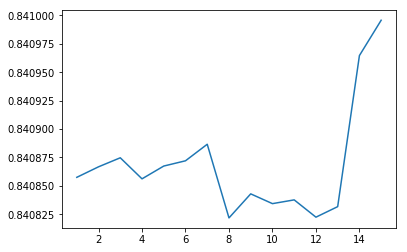

In [13]:
aucs = [];
parents = [x*1 for x in range(1,16)]

for i in parents:
    learner = ml.dtree.treeClassify(Xt, Yt, maxDepth=8, minLeaf=4, minParent=i);
    aucs.append(learner.auc(Xv, Yv));
    
plt.plot(parents, aucs);
plt.show();

# Random Forest

Try to use random forest.
Adjust one parameter while others are fixed.
bags -> features -> maxdepth -> minleaf.
Iteratively adjust parameters.

Since error rate will always decrease when #learners increases, we will use 100 learners for the final evaluation.

data

In [58]:
import numpy as np;
import matplotlib.pyplot as plt;
import mltools as ml;

X_test_src = np.genfromtxt("data/X_test.txt",delimiter=','); 
X_train_src = np.genfromtxt("data/X_train.txt",delimiter=','); # shape = (20k, 13)
Y_train_src = np.genfromtxt("data/Y_train.txt",delimiter=','); # Y = [0, 1]

X_test_src = X_test_src[1:,:];
X_train_src = X_train_src[1:,:];
Y_train_src = Y_train_src[1:];

Xtr,Ytr = X_train_src[0:18000,:], Y_train_src[0:18000];
Xv,Yv = X_train_src[18000:-1,:], Y_train_src[18000:-1] ;

Utility Function for test

In [59]:
def calculateAUC(Yhat, Y):
    soft = Yhat[:,1]  # p(class = 2nd)

    n,d = np.atleast_2d(soft).shape             # ensure soft is the correct shape
    soft = soft.flatten() if n==1 else soft.T.flatten()

    indices = np.argsort(soft)         # sort data by score value
    Y = Y[indices]
    sorted_soft = soft[indices]

    # compute rank (averaged for ties) of sorted data
    dif = np.hstack( ([True],np.diff(sorted_soft)!=0,[True]) )
    r1  = np.argwhere(dif).flatten()
    r2  = r1[0:-1] + 0.5*(r1[1:]-r1[0:-1]) + 0.5
    rnk = r2[np.cumsum(dif[:-1])-1]

    # number of true negatives and positives
    n0,n1 = sum(Y == 0), sum(Y ==1)

    if n0 == 0 or n1 == 0:
      raise ValueError('Data of both class values not found')

    # compute AUC using Mann-Whitney U statistic
    result = (np.sum(rnk[Y == 1]) - n1 * (n1 + 1.0) / 2.0) / n1 / n0
    return result    

number of learners/ensembles

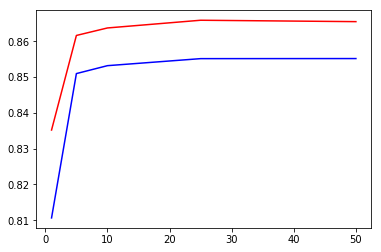

In [60]:
bags = np.array([1, 5, 10, 25, 50]);
aucT1 = [];
aucV1 = [];

ensembles = [ None ] * bags[len(bags)-1];
for k in range(bags[len(bags)-1]):
    # train forests
    Xt, Yt = ml.bootstrapData(Xtr, Ytr);
    ensembles[k] = ml.dtree.treeClassify(Xt, Yt, maxDepth=11, minLeaf=11, nFeatures = 3);

for k in range(len(bags)):    
    # predict
    predictT = np.zeros((Xtr.shape[0], 2));
    predictV = np.zeros((Xv.shape[0], 2));
    for i in range(bags[k]):
        predictT += ensembles[i].predictSoft(Xtr); 
        predictV += ensembles[i].predictSoft(Xv);
        
    predictT /= float(bags[k]);
    predictV /= float(bags[k]);
    
    aucT1.append(calculateAUC(predictT, Ytr));
    aucV1.append(calculateAUC(predictV, Yv));

plt.plot(bags, aucT1, 'red');
plt.plot(bags, aucV1, 'blue');
plt.show();

number of features

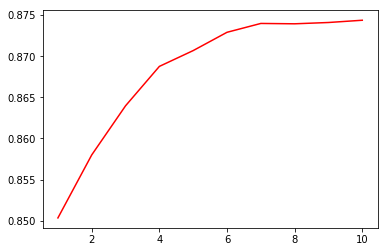

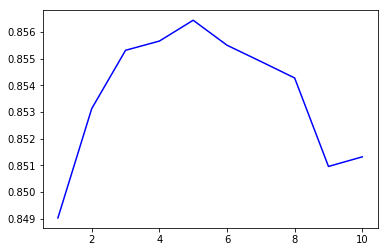

In [61]:
bag = 25;
features = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10];
aucT2 = [];
aucV2 = [];

for k in features:

    ensembles = [ None ] * bag;
    for i in range(bag):
        # train forests
        Xt, Yt = ml.bootstrapData(Xtr, Ytr);
        ensembles[i] = ml.dtree.treeClassify(Xt, Yt, maxDepth=11, minLeaf=11, nFeatures = k);

    predictT = np.zeros((Xtr.shape[0], 2));
    predictV = np.zeros((Xv.shape[0], 2));
    for i in range(bag):
        predictT += ensembles[i].predictSoft(Xtr); 
        predictV += ensembles[i].predictSoft(Xv);

    predictT /= float(bag);
    predictV /= float(bag);
    
    aucT2.append(calculateAUC(predictT, Ytr));
    aucV2.append(calculateAUC(predictV, Yv));

plt.plot(features, aucT2, 'red');
plt.show();
plt.plot(features, aucV2, 'blue');
plt.show();

maxDepth

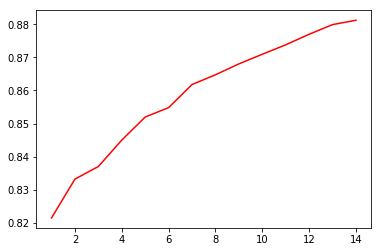

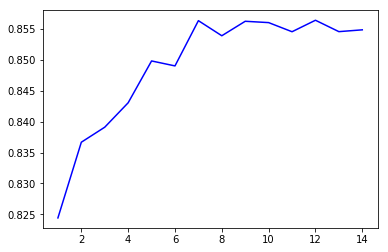

In [62]:
bag = 25;
feature = 5;
depths = list(range(1, 15));
aucT3 = [];
aucV3 = [];

for k in depths:

    ensembles = [ None ] * bag;
    for i in range(bag):
        # train forests
        Xt, Yt = ml.bootstrapData(Xtr, Ytr);
        ensembles[i] = ml.dtree.treeClassify(Xt, Yt, maxDepth=k, nFeatures = feature);

    predictT = np.zeros((Xtr.shape[0], 2));
    predictV = np.zeros((Xv.shape[0], 2));
    for i in range(bag):
        predictT += ensembles[i].predictSoft(Xtr); 
        predictV += ensembles[i].predictSoft(Xv);

    predictT /= float(bag);
    predictV /= float(bag);
    
    aucT3.append(calculateAUC(predictT, Ytr));
    aucV3.append(calculateAUC(predictV, Yv));

plt.plot(depths, aucT3, 'red');
plt.show();
plt.plot(depths, aucV3, 'blue');
plt.show();

minLeaf

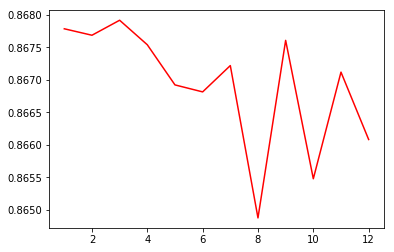

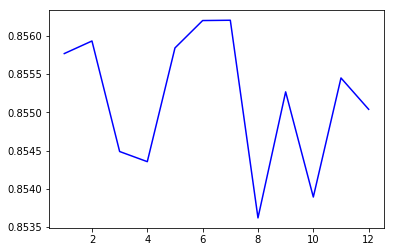

In [63]:
bag = 25;
feature = 5;
depth = 9;
leafs = list(range(1, 13));
aucT4 = [];
aucV4 = [];

for k in leafs:

    ensembles = [ None ] * bag;
    for i in range(bag):
        # train forests
        Xt, Yt = ml.bootstrapData(Xtr, Ytr);
        ensembles[i] = ml.dtree.treeClassify(Xt, Yt, maxDepth=depth, minLeaf=k, nFeatures = feature);

    predictT = np.zeros((Xtr.shape[0], 2));
    predictV = np.zeros((Xv.shape[0], 2));
    for i in range(bag):
        predictT += ensembles[i].predictSoft(Xtr); 
        predictV += ensembles[i].predictSoft(Xv);

    predictT /= float(bag);
    predictV /= float(bag);
    
    aucT4.append(calculateAUC(predictT, Ytr));
    aucV4.append(calculateAUC(predictV, Yv));

plt.plot(leafs, aucT4, 'red');
plt.show();
plt.plot(leafs, aucV4, 'blue');
plt.show();

In [64]:
bag = 50;
feature = 5;
depth = 9;
leaf = 6;

ensembles = [ None ] * bag;
for i in range(bag):
    Xt, Yt = ml.bootstrapData(X_train_src, Y_train_src);
    ensembles[i] = ml.dtree.treeClassify(Xt, Yt, maxDepth=depth, minLeaf=leaf, nFeatures = feature);

In [65]:
Yte = np.zeros((X_test_src.shape[0], 2));
for i in range(bag):
    Yte += ensembles[i].predictSoft(X_test_src);
Yte /= bag;

In [66]:
Yte1 = Yte[:,0];
fh = open('predictions.csv','w') # open file for upload
fh.write('ID,Prob1\n') # output header line
for i,yi in enumerate(Yte1):
    fh.write('{},{}\n'.format(i,yi)) # output each prediction
fh.close()

bag=30, feature=3, depth=11, leaf=11. auc = 0.85798;

bag=50, feature=5, depth=9, leaf=6. auc = 0.85804;
